# A causal look into the factors of world happiness [4-Estimations]

## intro
In this one we will try causal graph learning on our dataset. There are different algorithms to discover causal graphs from data. We are going to use `causal-learn` library.

Let's start with the usual dataset loading steps. Here the mapping of the variables:
```
Y: Ladder score
D: "treatment" status indicator, we will try to do some interventions
   on some subset of the records (for example, what happens if income raises...)
   this binary label will be set to 1 for the records that received the intervention.
X: a matrix of all the covariates used in the dataset (Y  S  J  X  W)
```

Discalimer: figures below may differ if recomputed as those are results of probabilistic models

Following from the [previous notebook](https://www.kaggle.com/code/lorenzogotuned/world-happiness-3-causal-learning).

## load the dataset

In [3]:
import pandas as pd
from causalinference import CausalModel
from tabulate import tabulate
from functools import partial
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
df = pd.read_csv('world-happiness-report-2021.csv')
df.drop(list(df.filter(regex='Explained')), axis=1, inplace=True)
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,2.798


In [5]:
df = df[["Ladder score",
         "Logged GDP per capita",
         "Social support",
         "Healthy life expectancy",
         "Freedom to make life choices"]
].copy()
df.rename(columns={
    "Ladder score": "Y",
    "Logged GDP per capita": "S",
    "Social support": "J",
    "Healthy life expectancy": "X",
    "Freedom to make life choices": "W" 
}, inplace=True)
df.head(5)

,Y,S,J,X,W
0,7.842,10.775,0.954,72.0,0.949
1,7.620,10.933,0.954,72.7,0.946
2,7.571,11.117,0.942,74.4,0.919
3,7.554,10.878,0.983,73.0,0.955
4,7.464,10.932,0.942,72.4,0.913


In [6]:
df.describe()

,Y,S,J,X,W
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.532839,9.432208,0.814745,64.992799,0.791597
std,1.073924,1.158601,0.114889,6.762043,0.113332
min,2.523000,6.635000,0.463000,48.478000,0.382000
25%,4.852000,8.541000,0.750000,59.802000,0.718000
50%,5.534000,9.569000,0.832000,66.603000,0.804000
75%,6.255000,10.421000,0.905000,69.600000,0.877000
max,7.842000,11.647000,0.983000,76.953000,0.970000


In [5]:
print(df.columns)

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

Index(['Y', 'S', 'J', 'X', 'W'], dtype='object')


In the previous post, using Peter-Clark (PC), we identified one causal graph in particular to focus our attention:

  0%|          | 0/5 [00:00<?, ?it/s]

Causal graph identified by causal learning


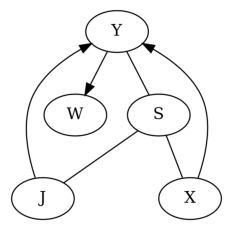

In [10]:
from causallearn.search.ConstraintBased.PC import pc
cg = pc(df.to_numpy())

print("Causal graph identified by causal learning")
# visualization using pydot
cg.draw_pydot_graph(labels=df.columns)

The graph discovered includes only 4 variables, there seems to be no causal relation that involves `S`.

## Estimation

Let's now perform multiple estimations for the ETA, ATC and ATT for this graph. This will allow a statistical analysis over the expected value of a variable after the intervention, that is expressed with:

$E(Y(1)-Y(0) )$

`Y(1)` is the value of the variable `Y` with intervention, while `Y(0)` otherwise. The indices that synthetise this expected values for all the data points in the dataset are:
* ATA: Average Treatment Effect
* ATC: Average Treatment Effect on Controls
* ATT: Average Treatment Effect on Treated

This is what we have done in notebook 2 for different causal graph hypothesis, we are going to proceed to a more detailed analysis on the graph identified by the causal learning (notebook 3).

Let's start by splitting the dataset in records that will receive the intervention and records that won't:



In [72]:
# randomise treatment in the dataset
import numpy as np
df["D"] = np.random.choice(a=[0,1], size=df["Y"].count(), p=[0.4, 0.6])
print(df["D"].to_numpy())

[1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0
 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0
 1]


We added a column `D` to define who will receive the treatment.

Let's remember the **foundamental assumptions** that make this kind of analysis formally complete.

These prerequisites must hold:

1. *randomized experiment* ("strong" prerequisite)

assignment of treatment must be random:

$(Y(0), Y(1)) ⟂ D$


2. *unconfounded assumption* ("weak" prerequisite)

exclude confounding among covariates (`X`), there is no unobserved confounder:

$(Y(0), Y(1)) ⟂ D|X$

Effects of treatment are orthogonal to treatment conditional covariates. This condition is checked automatically by causal inference libraries
by comparing conditional probabilities. 

## Interventions

After the application of causal learning we can direct our attention to the covariates that we assume are going to be the most meaningfull to our analysis. According to the causal graph above, we are going to establish which cause has the most influence on the "happiness", the two candidates have been identified in `X` life expectancy and `J` social support.

We are going to use a "matching" estimator. To overcome the excess of extrapolation in other estimation method, "matching" tries to compute on matching records with similar covariate values. It implies applying locally the linear approximation to values that are already similar.

### 0. Avoid covariate imbalance

To understand the state of covariate imbalance we need to compute the *propensity score*, *the probability of receiving treatment*. Thanks to some literature that starts with Rosenbaum/Rubin (1983) we can be confident that can compute the propensity score by matching on the probability distribution of the covariates aggregated across subjects. This is a consequence derived from the Unconfoundedness Assumption seen above (`X` here stays for the matrix of all the covariates):

$(Y(0), Y(1)) ⟂ D|X$

implies $(Y(0), Y(1)) ⟂ D|p(X)$  (use probability density instead of values)

that is $p(X) = P(D=1|X)$ (this allows for the Imbens/Rubin (2015) algorithm to compute the propensity score)

Let's compute the propensity score on the original (without interventions) dataset so to correct possible imbalances:

In [73]:
df_start = df.copy()

def compute_causal_model(covariates=df_start[["X", "J"]].to_numpy()):
    """ Compute the causal model by given covariates """
    return CausalModel(
        Y=df_start["Y"].to_numpy(),        # the effect
        D=df_start["D"].to_numpy(),        # the treatment assignment
        X=covariates                       # the covariates
    )



causal = compute_causal_model()

In [76]:
# propensity score according to Imbens, G. & Rubin, D. (2015)
causal.reset()
causal.est_propensity_s()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.536      0.170      3.157      0.002      0.203      0.869



> The propensity score is the conditional probability of
  receiving the treatment given the observed covariates.
  Estimation is done via a logistic regression.
  The covariate selection algorithm is based on a sequence
  of likelihood ratio tests.

Propensity score is foundamental to undestand relations between variables. This always implies comparative studies with different approaches to the causal graph. Experimenting on causal relations involves establishing hypothesis and compare them in a series of tests. For example, attributing probability distributions to causal mechanism (the arrows in a directed graph) can be an empirical process like trying different distributions (Bernoulli, Uniform, etc.) that fit better the data according to educated guesses and run an extensive comparison of the results.

This leads to the definition of different Structural Causal Models (SCMs) for which causal inference provides a variety of developing tools from hypothesis to counterfactuals.

In [78]:
# linear or quadratic propensity score
causal.reset()
causal.est_propensity()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.319      1.649      0.194      0.847     -2.913      3.551
            X0      0.024      0.037      0.666      0.506     -0.047      0.096
            X1     -1.676      2.189     -0.766      0.444     -5.966      2.614



Disclaimer: the original dataset used is only examplary and it is already normalised to linear relations so this kind of analysis is not very relevant; in the presence of a less worked dataset though, with values representing direct observations, this can be very relevant in asserting causal relations. 

We can try to test if a quadratic relation is in place by trying:

In [83]:
# try to have an idea if quadratic relations are relevant
causal.reset()
causal.est_propensity(qua=[(0,0), (1,1), (0,1)])
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      6.995     14.793      0.473      0.636    -21.998     35.989
            X0     -0.188      0.464     -0.405      0.686     -1.098      0.722
            X1     -1.158     20.471     -0.057      0.955    -41.282     38.966
         X0*X0     -0.000      0.005     -0.014      0.989     -0.010      0.010
         X1*X1    -12.038     18.037     -0.667      0.505    -47.391     23.315
         X0*X1      0.283      0.526      0.539      0.590     -0.747      1.314



In [92]:
# we use the Imbens, G. & Rubin, D. (2015) propensity for now
causal.reset()
causal.est_propensity_s()
causal.est_via_matching(matches=4, bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.009      0.100      0.087      0.931     -0.186      0.204
           ATC      0.004      0.101      0.037      0.970     -0.194      0.201
           ATT      0.012      0.101      0.114      0.909     -0.187      0.210



In the `Est.` column, we can see here the estimated influence on the effect for an intervention on the causes.

You can try to change the `matches` parameter that defines how many records should be involved in the matching. I assumed that 4 is a good parameter considering the size of the dataset.

### 1. improving life expectancy

Let's move now into using these tools in presence of interventions, we are going to do the same operations done in a previous post:

In [80]:
std_dev_X3 = df_start["X3"].std()
print(std_dev_X3 / 10)

mask = df_start["D"] == 1

df_intervention1 = df_start.copy()
# apply intervention
df_intervention1.loc[mask, 'X3'] = df_intervention1.loc[mask, "X3"].apply(lambda x: x + (std_dev_X3 / 10))
df_intervention1.head()

# we simplify the model considering only some covariates
causal_interv1 = CausalModel(
    Y=df_intervention1["Y"].to_numpy(),
    D=df_intervention1["D"].to_numpy(),
    X=df_intervention1[["X0", "X1", "X2", "X3"]].to_numpy()
)



KeyError: 'X3'

### 2. improving social support

### 3. Compare interventions